**Creating a toy multiclass dataset**

**blobs documentation link(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)**

In [184]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs  
from sklearn.model_selection import train_test_split

In [185]:
#set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000, 
n_features=NUM_FEATURES,
centers=NUM_CLASSES,
cluster_std = 1.5, #give a cluster a little shake up
random_state=RANDOM_SEED)

#turn our data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# #plot the data
# plt.figure(figsize=(10,7))
# plt.scatter(X_blob[:, 0], X_blob[:, 1],c=y_blob, cmap=plt.cm.RdYlBu);

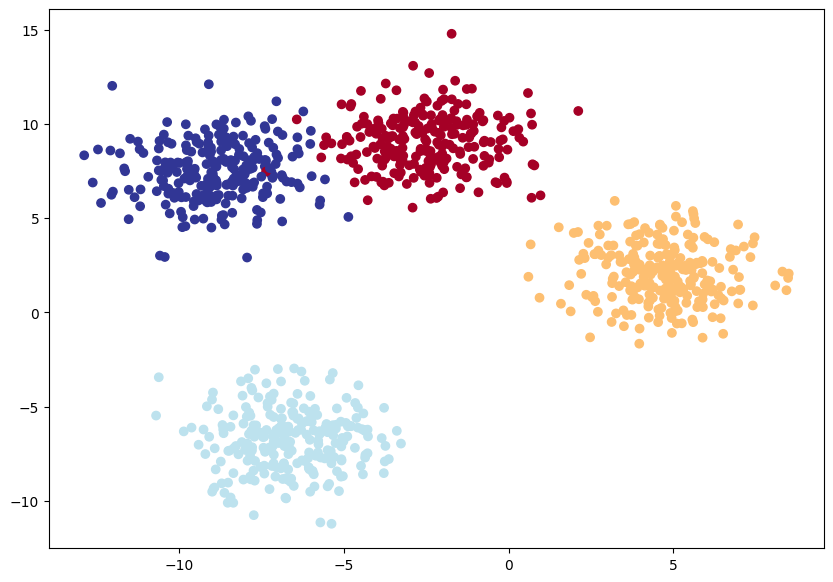

In [186]:
#plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1],c=y_blob, cmap=plt.cm.RdYlBu);

**Building a Multi-Class Classification Model**

In [187]:
#create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#device

In [188]:
#multi_class model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

#create an instance of the model
blob_model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
blob_model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [189]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [190]:
torch.unique(y_train)

tensor([0., 1., 2., 3.])

In [191]:
#create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=blob_model.parameters(), lr=0.1)

In [192]:
#calculate the accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [193]:
#training and test loop

torch.manual_seed(42)

epochs = 100

#put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device).long()
X_test, y_test = X_test.to(device), y_test.to(device).long()

#loop through data
for epoch in range(epochs):
    blob_model.train()
    y_logits = blob_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Testing code
    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        #print whats happening
        if epoch % 10 ==0:
            print(f"Epoch: {epoch} | loss: {loss:.4f}, acc: {acc:.2f}% | test_loss: {test_loss:.4f}, test_acc: {test_acc:.2f}%")


Epoch: 0 | loss: 1.1588, acc: 40.38% | test_loss: 1.0755, test_acc: 48.00%
Epoch: 10 | loss: 0.6448, acc: 96.75% | test_loss: 0.6607, test_acc: 97.50%
Epoch: 20 | loss: 0.4254, acc: 98.50% | test_loss: 0.4307, test_acc: 100.00%
Epoch: 30 | loss: 0.2529, acc: 99.12% | test_loss: 0.2451, test_acc: 99.50%
Epoch: 40 | loss: 0.1123, acc: 99.25% | test_loss: 0.1023, test_acc: 99.50%
Epoch: 50 | loss: 0.0663, acc: 99.25% | test_loss: 0.0585, test_acc: 99.50%
Epoch: 60 | loss: 0.0507, acc: 99.25% | test_loss: 0.0429, test_acc: 99.50%
Epoch: 70 | loss: 0.0430, acc: 99.25% | test_loss: 0.0349, test_acc: 99.50%
Epoch: 80 | loss: 0.0384, acc: 99.25% | test_loss: 0.0299, test_acc: 99.50%
Epoch: 90 | loss: 0.0352, acc: 99.25% | test_loss: 0.0266, test_acc: 99.50%


In [ ]:
#making and evaluating predictions


In [194]:
#make prdictions
import requests
from pathlib import Path

#download the helper function from the pytorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


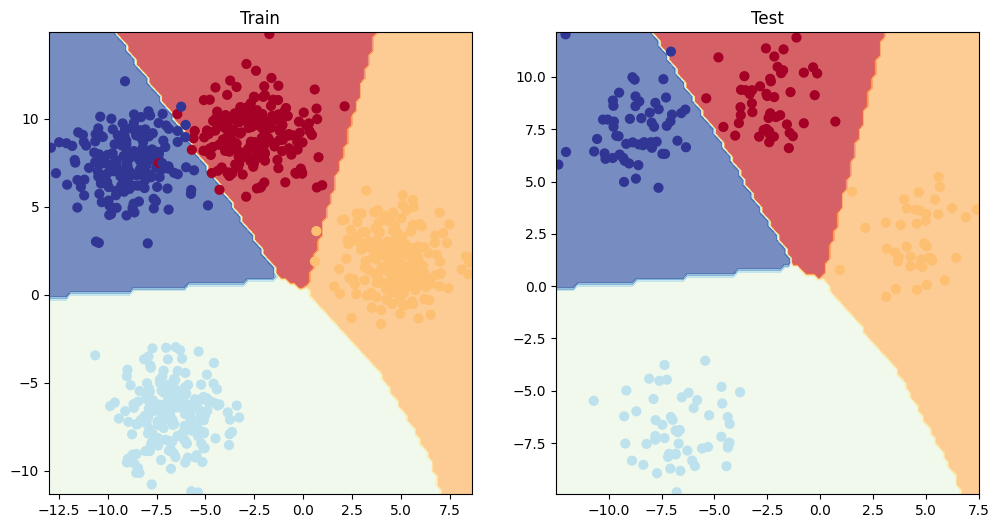

In [195]:
#plot decision boundry of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blob_model, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blob_model, X_test, y_test)